In [7]:
!pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   --------- ------------------------------ 71.7/294.9 kB 2.0 MB/s eta 0:00:01
   ------------------------------ --------- 225.3/294.9 kB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import pandas as pd
import math

def dist(uex, uey, cellx, celly):
    return math.sqrt((uex - cellx)**2 + (uey - celly)**2)

def process_ues(ue_file):
    cells = pd.read_csv('./data/cells.csv')
    ues = pd.read_csv(ue_file)

    # Ensure 'throughput(Kbps)' is of type float
    ues['throughput(Kbps)'] = ues['throughput(Kbps)'].astype(float)
    cells['currCapacity'] = cells['maxCapacity-Kbps'].astype(float)  # Initialize current capacity

    policy = {
        '1': {'p1': 'macro', 'p2': 'pico', 'p3': 'anchored'},
        '2': {'p1': 'macro', 'p2': 'anchored', 'p3': 'pico'},
        '3': {'p1': 'pico', 'p2': 'anchored', 'p3': 'macro'},
        '4': {'p1': 'anchored', 'p2': 'macro', 'p3': 'pico'}
    }

    oloads = []
    unmanaged = 0

    def findCell(id, preference, x, y, throughput, preference_level):
        if preference == 'macro':
            availableCells = cells[(cells.pico == 0) & (cells.anchored == 0)]
        elif preference == 'pico':
            availableCells = cells[(cells.pico == 1) & (cells.anchored == 0)]
        elif preference == 'anchored':
            availableCells = cells[cells.anchored == 1]
        else:
            availableCells = pd.DataFrame()  # Empty DataFrame if preference doesn't match

        distances = []
        for i in range(len(availableCells)):
            distances.append(dist(x, y, availableCells.iloc[i]['x'], availableCells.iloc[i]['y']))
        availableCells['distance'] = distances
        availableCells = availableCells.sort_values('distance')

        for i in range(len(availableCells)):
            ac = availableCells.iloc[i]
            cell = cells.loc[cells['id'] == ac['id']]
            x = float(cell['currCapacity'])
            if (x - throughput) < 0:
                oloads.append(1)
            else:
                cell['currCapacity'] -= throughput
                cells.loc[cells['id'] == ac['id']] = cell
                return ac['id'], preference_level
        return False, None

    ues['preference_level'] = None
    ues['allocatedCell'] = None

    for i in range(len(ues)):
        s = int(ues.loc[i]['slice'])
        ue = ues.loc[i]
        pref = policy[str(s)]
        res1, pref_level1 = findCell(int(ue['id']), pref['p1'], ue['x'], ue['y'], ue['throughput(Kbps)'], 1)
        if res1 != False:
            ue['allocatedCell'] = res1
            ue['preference_level'] = 'first'
            ues.loc[i] = ue
        else:
            res2, pref_level2 = findCell(ue['id'], pref['p2'], ue['x'], ue['y'], ue['throughput(Kbps)'], 2)
            if res2 != False:
                ue['allocatedCell'] = res2
                ue['preference_level'] = 'second'
                ues.loc[i] = ue
            else:
                res3, pref_level3 = findCell(ue['id'], pref['p3'], ue['x'], ue['y'], ue['throughput(Kbps)'], 3)
                if res3 != False:
                    ue['allocatedCell'] = res3
                    ue['preference_level'] = 'third'
                    ues.loc[i] = ue
                else:
                    unmanaged += 1
                    ue['preference_level'] = 'unmanaged'
                    ues.loc[i] = ue

    preference_counts = ues['preference_level'].value_counts()
    total_ues = len(ues)
    preference_ratios = (preference_counts / total_ues) * 100

    num_managed = total_ues - unmanaged

    print(f"Results for {ue_file}:")
    print("Total UEs:", total_ues)
    print("Managed UEs:", num_managed)
    print("Unmanaged UEs:", unmanaged)
    print("Preference Satisfaction Counts:")
    print(preference_counts)
    print("\nPreference Satisfaction Ratios (%):")
    print(preference_ratios)
    print("Overloads:", len(oloads))
    print("--------------\n")

    # Save the allocation results if needed
    # ues.to_csv(f'allocated_{ue_file}', index=False)

    return {
        'ue_file': ue_file,
        'total_ues': total_ues,
        'managed_ues': num_managed,
        'unmanaged_ues': unmanaged,
        'preference_counts': preference_counts,
        'preference_ratios': preference_ratios
    }
    
ue_files = [
    './data/data.csv',
    './data/new_data.csv',
    './data/new_data_350.csv',
    './data/new_data_500.csv',
    './data/new_data_1000.csv'
]

results = []

for ue_file in ue_files:
    res = process_ues(ue_file)
    results.append(res)


C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\201849845.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  availableCells['distance'] = distances
C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\201849845.py:44: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(cell['currCapacity'])
C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\201849845.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cel

Results for ./data/data.csv:
Total UEs: 250
Managed UEs: 250
Unmanaged UEs: 0
Preference Satisfaction Counts:
preference_level
first     232
second     17
third       1
Name: count, dtype: int64

Preference Satisfaction Ratios (%):
preference_level
first     92.8
second     6.8
third      0.4
Name: count, dtype: float64
Overloads: 154
--------------

Results for ./data/new_data.csv:
Total UEs: 50
Managed UEs: 50
Unmanaged UEs: 0
Preference Satisfaction Counts:
preference_level
first    50
Name: count, dtype: int64

Preference Satisfaction Ratios (%):
preference_level
first    100.0
Name: count, dtype: float64
Overloads: 0
--------------



C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\201849845.py:44: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(cell['currCapacity'])
C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\201849845.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell['currCapacity'] -= throughput
C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\201849845.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ue['allocatedCell'] = res1
C:\Users\utkar\AppData\Local\Temp\ipy

Results for ./data/new_data_350.csv:
Total UEs: 350
Managed UEs: 318
Unmanaged UEs: 32
Preference Satisfaction Counts:
preference_level
first        270
second        41
unmanaged     32
third          7
Name: count, dtype: int64

Preference Satisfaction Ratios (%):
preference_level
first        77.142857
second       11.714286
unmanaged     9.142857
third         2.000000
Name: count, dtype: float64
Overloads: 579
--------------



C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\201849845.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  availableCells['distance'] = distances
C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\201849845.py:44: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(cell['currCapacity'])
C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\201849845.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cel

Results for ./data/new_data_500.csv:
Total UEs: 500
Managed UEs: 350
Unmanaged UEs: 150
Preference Satisfaction Counts:
preference_level
first        270
unmanaged    150
second        65
third         15
Name: count, dtype: int64

Preference Satisfaction Ratios (%):
preference_level
first        54.0
unmanaged    30.0
second       13.0
third         3.0
Name: count, dtype: float64
Overloads: 1854
--------------



C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\201849845.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  availableCells['distance'] = distances
C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\201849845.py:44: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(cell['currCapacity'])
C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\201849845.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cel

Results for ./data/new_data_1000.csv:
Total UEs: 1000
Managed UEs: 350
Unmanaged UEs: 650
Preference Satisfaction Counts:
preference_level
unmanaged    650
first        270
second        65
third         15
Name: count, dtype: int64

Preference Satisfaction Ratios (%):
preference_level
unmanaged    65.0
first        27.0
second        6.5
third         1.5
Name: count, dtype: float64
Overloads: 6854
--------------



C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\201849845.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ue['preference_level'] = 'unmanaged'
C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\201849845.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  availableCells['distance'] = distances
C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\201849845.py:44: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(cell['currCapacity'])
C:\Users\utkar\AppData\

In [15]:
def run_static_policy(ue_file, cells_file='./data/cells.csv'):
    import pandas as pd
    import math

    # Function to calculate Euclidean distance between a UE and a cell
    def dist(uex, uey, cellx, celly):
        return math.sqrt((uex - cellx)**2 + (uey - celly)**2)

    # Load cells data
    cells = pd.read_csv(cells_file)
    cells['currCapacity'] = cells['maxCapacity-Kbps'].astype(float)  # Initialize current capacity
    cells['maxCapacity-Kbps'] = cells['maxCapacity-Kbps'].astype(float)

    # Load UE data
    ues = pd.read_csv(ue_file)
    ues['throughput(Kbps)'] = ues['throughput(Kbps)'].astype(float)

    policy = {
        '1': {'p1': 'macro', 'p2': 'pico', 'p3': 'anchored'},
        '2': {'p1': 'macro', 'p2': 'anchored', 'p3': 'pico'},
        '3': {'p1': 'pico', 'p2': 'anchored', 'p3': 'macro'},
        '4': {'p1': 'anchored', 'p2': 'macro', 'p3': 'pico'}
    }

    unmanaged = 0

    def findCell(id, preference, x, y, throughput, preference_level):
        if preference == 'macro':
            availableCells = cells[(cells.pico == 0) & (cells.anchored == 0)]
        elif preference == 'pico':
            availableCells = cells[(cells.pico == 1) & (cells.anchored == 0)]
        elif preference == 'anchored':
            availableCells = cells[cells.anchored == 1]
        else:
            availableCells = pd.DataFrame()

        if availableCells.empty:
            return False, None

        distances = []
        for i in range(len(availableCells)):
            distances.append(dist(x, y, availableCells.iloc[i]['x'], availableCells.iloc[i]['y']))
        availableCells['distance'] = distances
        availableCells = availableCells.sort_values('distance')

        for idx, ac in availableCells.iterrows():
            cell = cells.loc[cells['id'] == ac['id']]
            curr_capacity = float(cell['currCapacity'])
            if (curr_capacity - throughput) >= 0:
                cell['currCapacity'] -= throughput
                cells.loc[cells['id'] == ac['id'], 'currCapacity'] = cell['currCapacity']
                return ac['id'], preference_level
        return False, None

    ues['preference_level'] = None
    ues['allocatedCell'] = None

    for idx, ue in ues.iterrows():
        s = int(ue['slice'])
        pref = policy[str(s)]
        res1, pref_level1 = findCell(int(ue['id']), pref['p1'], ue['x'], ue['y'], ue['throughput(Kbps)'], 'first')
        if res1 != False:
            ue['allocatedCell'] = res1
            ue['preference_level'] = 'first'
            ues.loc[idx] = ue
        else:
            res2, pref_level2 = findCell(ue['id'], pref['p2'], ue['x'], ue['y'], ue['throughput(Kbps)'], 'second')
            if res2 != False:
                ue['allocatedCell'] = res2
                ue['preference_level'] = 'second'
                ues.loc[idx] = ue
            else:
                res3, pref_level3 = findCell(ue['id'], pref['p3'], ue['x'], ue['y'], ue['throughput(Kbps)'], 'third')
                if res3 != False:
                    ue['allocatedCell'] = res3
                    ue['preference_level'] = 'third'
                    ues.loc[idx] = ue
                else:
                    unmanaged += 1
                    ue['preference_level'] = 'unmanaged'
                    ue['allocatedCell'] = 0  # Indicate no allocation
                    ues.loc[idx] = ue

    # Calculate total throughput allocated per cell
    allocated_ues = ues[ues['allocatedCell'] != 0]
    cells_allocated_throughput = allocated_ues.groupby('allocatedCell')['throughput(Kbps)'].sum()

    # Compare allocated throughput to cell capacities
    cell_capacities = cells.set_index('id')['maxCapacity-Kbps']
    cell_utilization = (cells_allocated_throughput / cell_capacities) * 100

    # Store cell utilization data
    cell_utilization_static = cell_utilization.fillna(0).reset_index()
    cell_utilization_static.columns = ['cell_id', 'utilization_percentage']

    # Add method and ue_file for identification
    cell_utilization_static['method'] = 'Static Policy'
    cell_utilization_static['ue_file'] = ue_file

    return cell_utilization_static

ue_files = [
    './data/data.csv',
    './data/new_data.csv',
    './data/new_data_350.csv',
    './data/new_data_500.csv',
    './data/new_data_1000.csv'
]

results_cell_util = []

for ue_file in ue_files:
    res = run_static_policy(ue_file)
    results_cell_util.append(res)


C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\3825196346.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  availableCells['distance'] = distances
C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\3825196346.py:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  curr_capacity = float(cell['currCapacity'])
C:\Users\utkar\AppData\Local\Temp\ipykernel_16540\3825196346.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [16]:
results_cell_util

[   cell_id  utilization_percentage         method          ue_file
 0      1.0               85.550600  Static Policy  ./data/data.csv
 1      2.0               98.180667  Static Policy  ./data/data.csv
 2      3.0               99.134333  Static Policy  ./data/data.csv
 3      4.0               99.813200  Static Policy  ./data/data.csv
 4      5.0               99.310667  Static Policy  ./data/data.csv
 5      6.0               95.577667  Static Policy  ./data/data.csv
 6      7.0               96.446667  Static Policy  ./data/data.csv
 7      8.0               99.886000  Static Policy  ./data/data.csv
 8      9.0               99.350000  Static Policy  ./data/data.csv
 9     10.0               51.155500  Static Policy  ./data/data.csv,
    cell_id  utilization_percentage         method              ue_file
 0      1.0                1.127400  Static Policy  ./data/new_data.csv
 1      2.0                0.000000  Static Policy  ./data/new_data.csv
 2      3.0               48.933000

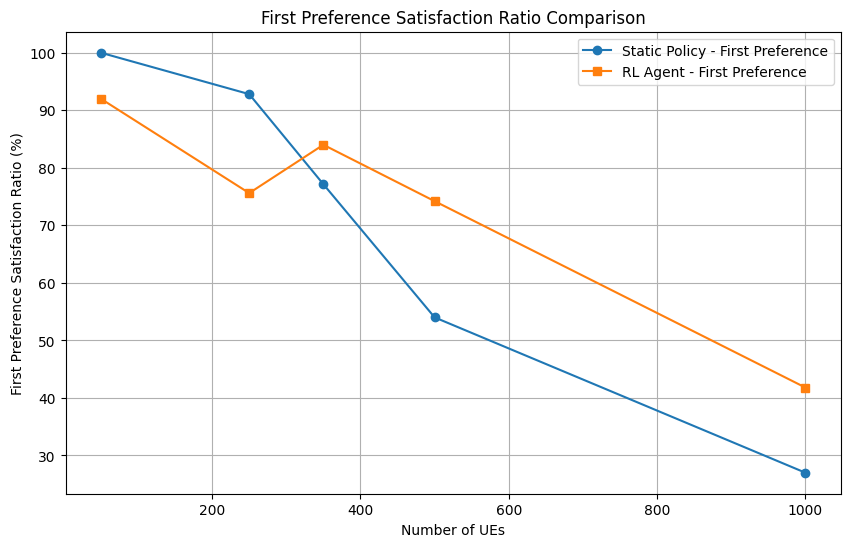

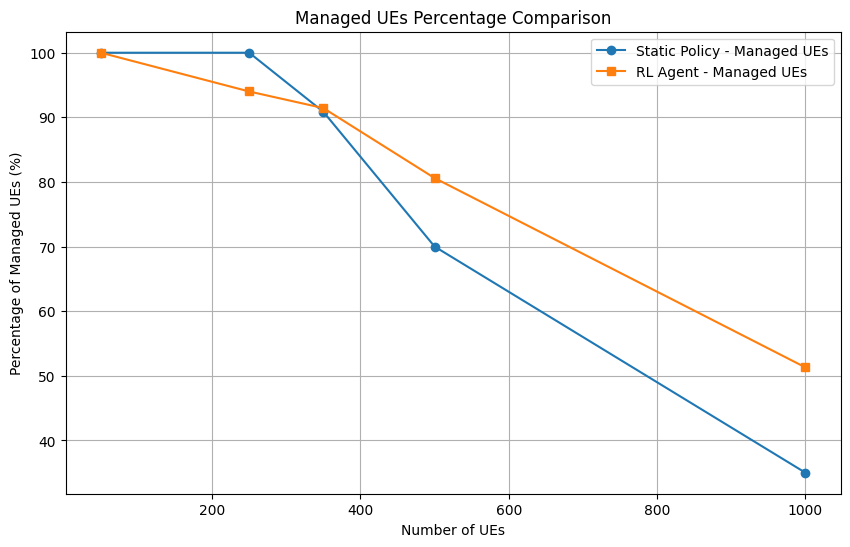

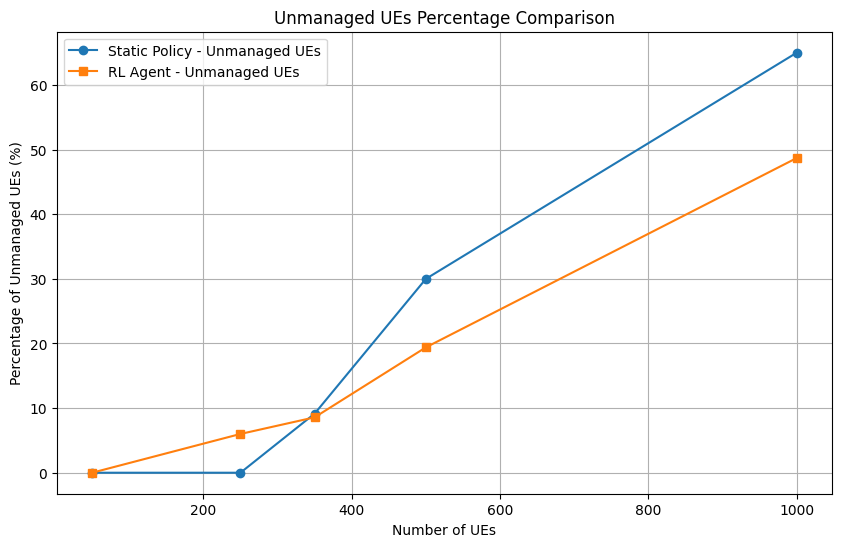

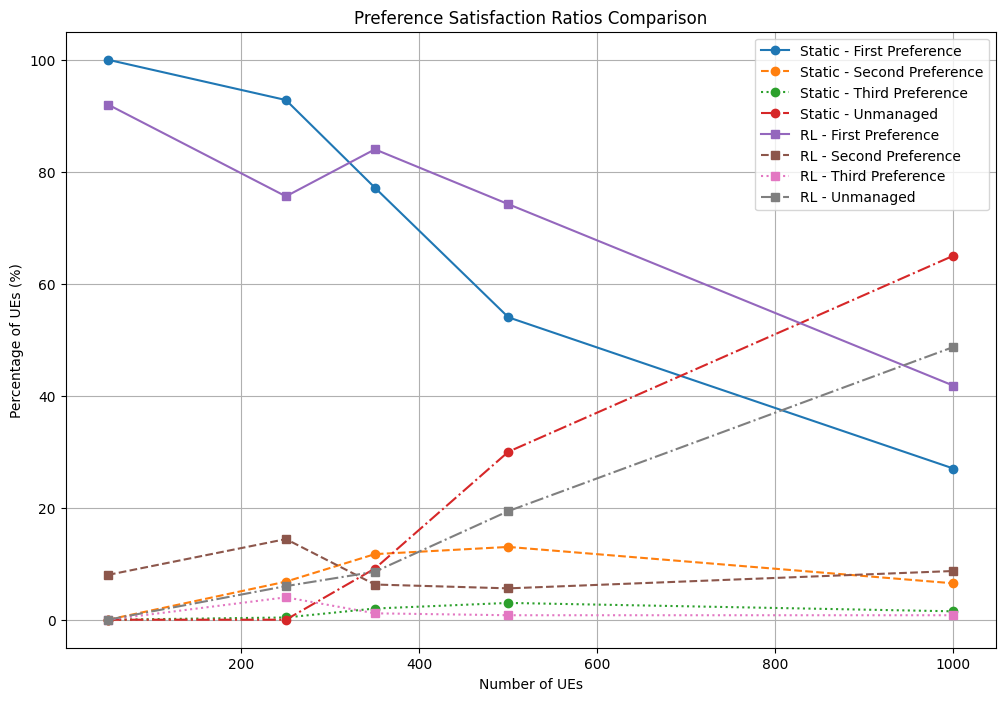

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Static Policy Data
static_data = {
    'UE_File': ['new_data.csv', 'data.csv', 'new_data_350.csv', 'new_data_500.csv', 'new_data_1000.csv'],
    'Total_UEs': [50, 250, 350, 500, 1000],
    'Managed_UEs': [50, 250, 318, 350, 350],
    'Unmanaged_UEs': [0, 0, 32, 150, 650],
    'First_Preference': [50, 232, 270, 270, 270],
    'Second_Preference': [0, 17, 41, 65, 65],
    'Third_Preference': [0, 1, 7, 15, 15],
    'Unmanaged_Preference': [0, 0, 32, 150, 650]
}

static_df = pd.DataFrame(static_data)

# RL Agent Data
rl_data = {
    'UE_File': ['UEs 50', 'UEs 250', 'UEs 350', 'UEs 500', 'UEs 1000'],
    'Total_UEs': [50, 250, 350, 500, 1000],
    'Unmanaged_UEs': [0, 15, 30, 97, 487],
    'First_Preference': [46, 189, 294, 371, 418],
    'Second_Preference': [4, 36, 22, 28, 87],
    'Third_Preference': [0, 10, 4, 4, 8],
    'Unmanaged_Preference': [0, 15, 30, 97, 487]
}

rl_df = pd.DataFrame(rl_data)

# Calculate preference satisfaction ratios
for df in [static_df, rl_df]:
    df['First_Pref_Ratio'] = (df['First_Preference'] / df['Total_UEs']) * 100
    df['Second_Pref_Ratio'] = (df['Second_Preference'] / df['Total_UEs']) * 100
    df['Third_Pref_Ratio'] = (df['Third_Preference'] / df['Total_UEs']) * 100
    df['Unmanaged_Ratio'] = (df['Unmanaged_UEs'] / df['Total_UEs']) * 100
    df['Managed_Ratio'] = ((df['Total_UEs'] - df['Unmanaged_UEs']) / df['Total_UEs']) * 100

# Standardize UE_File names for consistency
static_df['UE_File'] = static_df['Total_UEs']
rl_df['UE_File'] = rl_df['Total_UEs']

# Sort DataFrames by Total_UEs
static_df = static_df.sort_values('Total_UEs')
rl_df = rl_df.sort_values('Total_UEs')

# Plot First Preference Satisfaction Ratios
plt.figure(figsize=(10, 6))
plt.plot(static_df['Total_UEs'], static_df['First_Pref_Ratio'], marker='o', label='Static Policy - First Preference')
plt.plot(rl_df['Total_UEs'], rl_df['First_Pref_Ratio'], marker='s', label='RL Agent - First Preference')
plt.xlabel('Number of UEs')
plt.ylabel('First Preference Satisfaction Ratio (%)')
plt.title('First Preference Satisfaction Ratio Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot Managed UEs Percentage
plt.figure(figsize=(10, 6))
plt.plot(static_df['Total_UEs'], static_df['Managed_Ratio'], marker='o', label='Static Policy - Managed UEs')
plt.plot(rl_df['Total_UEs'], rl_df['Managed_Ratio'], marker='s', label='RL Agent - Managed UEs')
plt.xlabel('Number of UEs')
plt.ylabel('Percentage of Managed UEs (%)')
plt.title('Managed UEs Percentage Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot Unmanaged UEs Percentage
plt.figure(figsize=(10, 6))
plt.plot(static_df['Total_UEs'], static_df['Unmanaged_Ratio'], marker='o', label='Static Policy - Unmanaged UEs')
plt.plot(rl_df['Total_UEs'], rl_df['Unmanaged_Ratio'], marker='s', label='RL Agent - Unmanaged UEs')
plt.xlabel('Number of UEs')
plt.ylabel('Percentage of Unmanaged UEs (%)')
plt.title('Unmanaged UEs Percentage Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot All Preference Satisfaction Ratios
plt.figure(figsize=(12, 8))
plt.plot(static_df['Total_UEs'], static_df['First_Pref_Ratio'], marker='o', linestyle='-', label='Static - First Preference')
plt.plot(static_df['Total_UEs'], static_df['Second_Pref_Ratio'], marker='o', linestyle='--', label='Static - Second Preference')
plt.plot(static_df['Total_UEs'], static_df['Third_Pref_Ratio'], marker='o', linestyle=':', label='Static - Third Preference')
plt.plot(static_df['Total_UEs'], static_df['Unmanaged_Ratio'], marker='o', linestyle='-.', label='Static - Unmanaged')

plt.plot(rl_df['Total_UEs'], rl_df['First_Pref_Ratio'], marker='s', linestyle='-', label='RL - First Preference')
plt.plot(rl_df['Total_UEs'], rl_df['Second_Pref_Ratio'], marker='s', linestyle='--', label='RL - Second Preference')
plt.plot(rl_df['Total_UEs'], rl_df['Third_Pref_Ratio'], marker='s', linestyle=':', label='RL - Third Preference')
plt.plot(rl_df['Total_UEs'], rl_df['Unmanaged_Ratio'], marker='s', linestyle='-.', label='RL - Unmanaged')

plt.xlabel('Number of UEs')
plt.ylabel('Percentage of UEs (%)')
plt.title('Preference Satisfaction Ratios Comparison')
plt.legend()
plt.grid(True)
plt.show()


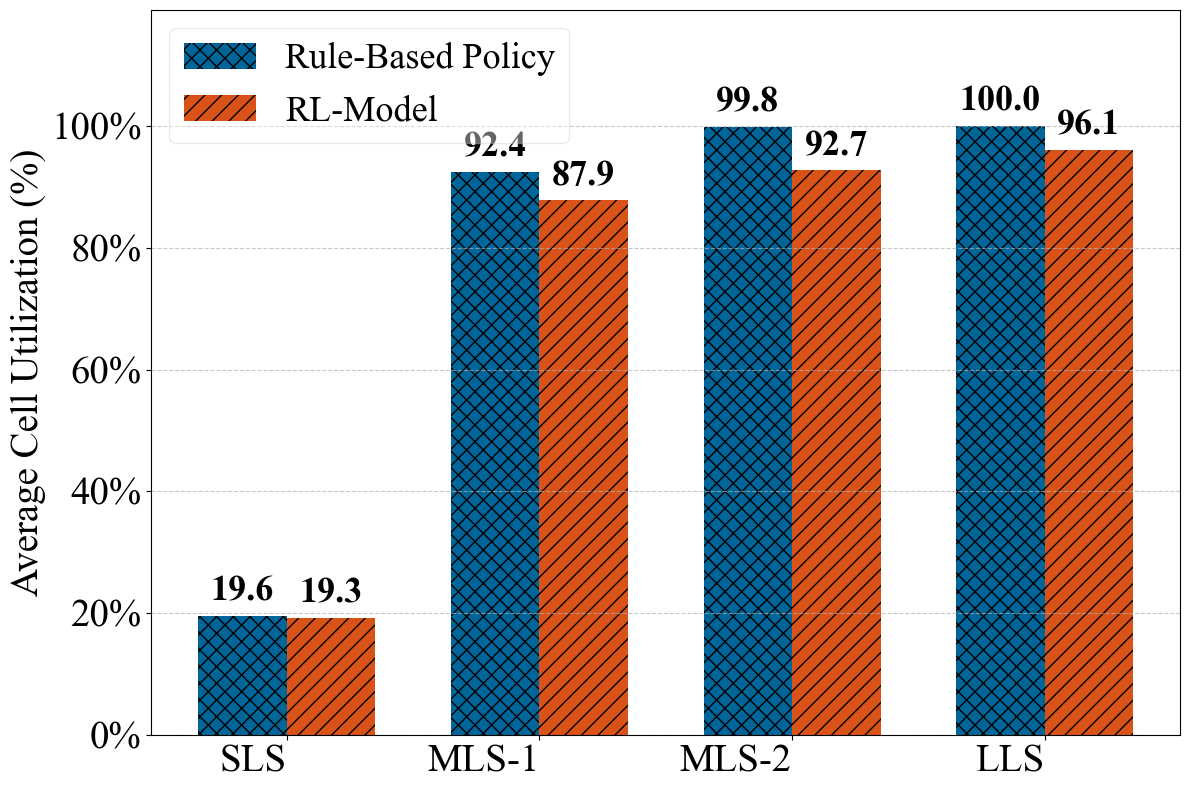

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data for RL Agent
data_rl = [
    pd.DataFrame({
        'cell_id': range(1, 11),
        'utilization_percentage': [15.5028, 20.814333, 53.458667, 0.0, 12.407, 20.648333, 37.966667, 14.720333, 14.7276, 2.5665],
        'method': 'RL Agent',
        'ue_file': './data/new_data.csv'  # 50 UEs - Small Load
    }),
    pd.DataFrame({
        'cell_id': range(1, 11),
        'utilization_percentage': [90.6572, 89.484, 88.974667, 84.2466, 88.124667, 98.502, 94.872667, 92.392, 75.0336, 76.5475],
        'method': 'RL Agent',
        'ue_file': './data/data.csv'  # 250 UEs - Medium Load 1
    }),
    pd.DataFrame({
        'cell_id': range(1, 11),
        'utilization_percentage': [99.6968, 99.008667, 91.760333, 89.7502, 94.933, 98.502, 98.698333, 92.392, 82.7256, 79.9255],
        'method': 'RL Agent',
        'ue_file': './data/new_data_350.csv'  # 350 UEs - Medium Load 2
    }),
    pd.DataFrame({
        'cell_id': range(1, 11),
        'utilization_percentage': [99.9972, 99.676333, 95.997667, 95.2452, 94.933, 98.502, 99.964, 92.392, 84.0556, 99.9965],
        'method': 'RL Agent',
        'ue_file': './data/new_data_1000.csv'  # 1000 UEs - Large Load
    })
]

# Data for Rule-Based Policy
data_rule_based = [
    pd.DataFrame({
        'cell_id': range(1, 11),
        'utilization_percentage': [1.1274, 0.0, 48.933, 6.8406, 50.43, 0.0, 20.814333, 61.974333, 3.2336, 2.5665],
        'method': 'Rule-Based',
        'ue_file': './data/new_data.csv'  # 50 UEs - Small Load
    }),
    pd.DataFrame({
        'cell_id': range(1, 11),
        'utilization_percentage': [85.5506, 98.180667, 99.134333, 99.8132, 99.310667, 95.577667, 96.446667, 99.886, 99.35, 51.1555],
        'method': 'Rule-Based',
        'ue_file': './data/data.csv'  # 250 UEs - Medium Load 1
    }),
    pd.DataFrame({
        'cell_id': range(1, 11),
        'utilization_percentage': [99.974, 99.384667, 99.967333, 99.9734, 99.513333, 99.998667, 99.614, 99.967667, 99.9168, 99.991],
        'method': 'Rule-Based',
        'ue_file': './data/new_data_350.csv'  # 350 UEs - Medium Load 2
    }),
    pd.DataFrame({
        'cell_id': range(1, 11),
        'utilization_percentage': [99.9948, 99.992, 99.997333, 99.9946, 99.997333, 99.998667, 99.991333, 99.996333, 99.9912, 99.991],
        'method': 'Rule-Based',
        'ue_file': './data/new_data_1000.csv'  # 1000 UEs - Large Load
    })
]

# Labels for the load systems
load_systems = [
    'SLS',
    'MLS-1',
    'MLS-2',
    'LLS'
]

# Calculate average utilization for each load system and method
average_utilizations = []
methods = ['Rule-Based', 'RL Agent']

for i in range(len(data_rl)):
    # Average utilization for RL Agent
    avg_rl = data_rl[i]['utilization_percentage'].mean()
    # Average utilization for Rule-Based Policy
    avg_rule = data_rule_based[i]['utilization_percentage'].mean()
    average_utilizations.append({
        'load_system': load_systems[i],
        'Rule-Based': avg_rule,
        'RL Agent': avg_rl
    })

# Create a DataFrame for plotting
df_avg = pd.DataFrame(average_utilizations)

# Plotting
# Define colors and hatch patterns
rule_based_color = '#006699'  # Dark teal for Rule-Based Policy
rl_based_color = '#D95319'    # Dark red for RL-Based Algorithm
rule_based_hatch = 'xx'       # Hatch pattern for Rule-Based
rl_based_hatch = '//'         # Hatch pattern for RL-Based
x = np.arange(len(df_avg['load_system']))  # Number of load systems
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - width/2, df_avg['Rule-Based'], width, label='Rule-Based Policy', color=rule_based_color, hatch=rule_based_hatch)
rects2 = ax.bar(x + width/2, df_avg['RL Agent'], width, label='RL-Model', color=rl_based_color, hatch=rl_based_hatch)

# Increase font sizes
plt.rcParams['font.family'] = 'Times New Roman'

rect_fontsize = 26  # Font size for bar labels
label_fontsize = 28
tick_fontsize = 28
title_fontsize = 26
legend_fontsize = 26

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Average Cell Utilization (%)', fontsize=label_fontsize)
# ax.set_title('Comparison of Average Cell Utilization Percentages', fontsize=title_fontsize)
ax.set_xticks(x)
ax.set_xticklabels(df_avg['load_system'], rotation=0, ha='right', fontsize=tick_fontsize)
ax.set_ylim(0, 119)

# Set tick parameters for y-axis
ax.tick_params(axis='y', labelsize=tick_fontsize)

# Format y-axis tick labels as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))

# Increase legend font size
ax.legend(fontsize=legend_fontsize, framealpha=0.4)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Function to add labels on top of bars
def autolabel(rects):
    """Attach a text label above each bar displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # Offset label position
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=rect_fontsize, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


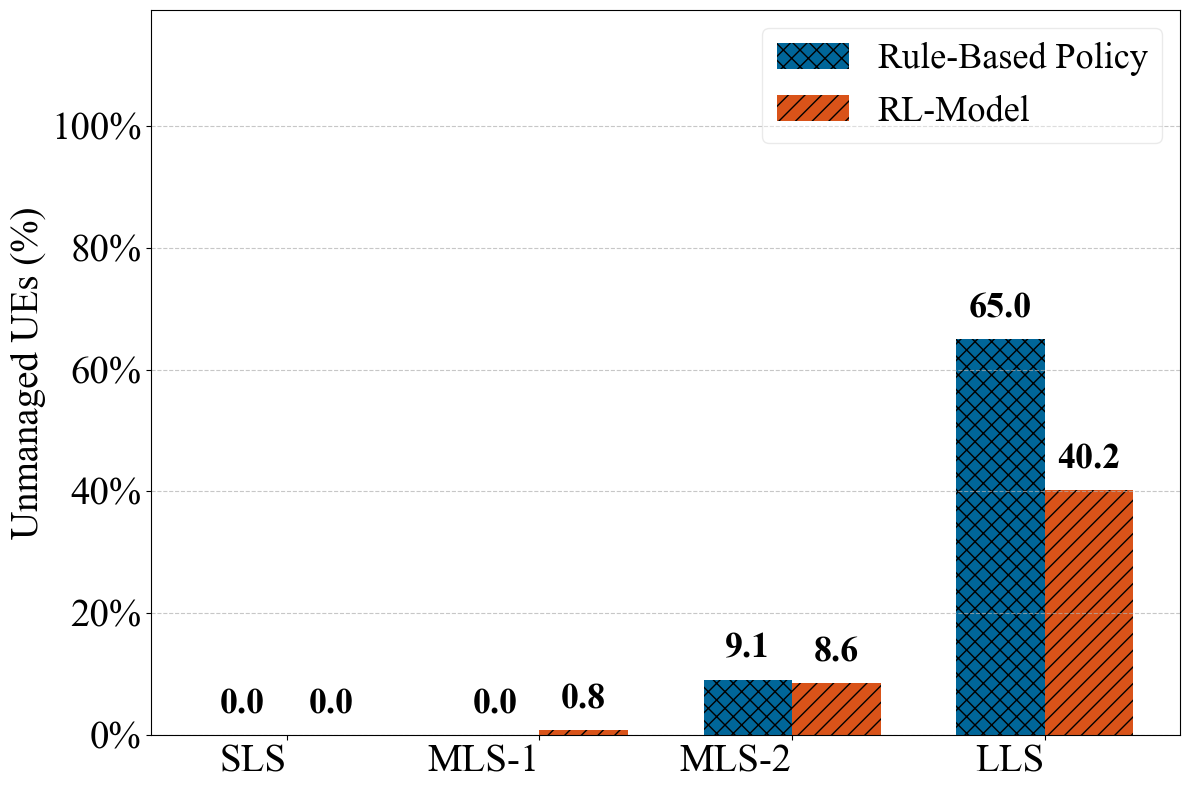

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data from RL-Based Algorithm
rl_data = {
    'Load_System': ['SLS', 'MLS-1', 'MLS-2', 'LLS'],
    'Total_UEs': [50, 250, 350, 1000],
    'Unmanaged_UEs': [0, 2, 30, 402],
    'First_Preference': [49, 236, 308, 586],
    'Second_Preference': [1, 10, 10, 10],
    'Third_Preference': [0, 2, 2, 2]
}
rl_df = pd.DataFrame(rl_data)
# Calculate percentage for RL
rl_df['Unmanaged_Percentage'] = (rl_df['Unmanaged_UEs'] / rl_df['Total_UEs']) * 100

# Data from Rule-Based Policy
rule_based_data = {
    'Load_System': ['SLS', 'MLS-1', 'MLS-2', 'LLS'],
    'Total_UEs': [50, 250, 350, 1000],
    'Unmanaged_UEs': [0, 0, 32, 650],
    'First_Preference': [50, 232, 270, 270],
    'Second_Preference': [0, 17, 41, 65],
    'Third_Preference': [0, 1, 7, 15]
}
rule_based_df = pd.DataFrame(rule_based_data)
# Calculate percentage for Rule-Based
rule_based_df['Unmanaged_Percentage'] = (rule_based_df['Unmanaged_UEs'] / rule_based_df['Total_UEs']) * 100

# Merge the percentage data for plotting
merged_df = rl_df[['Load_System', 'Unmanaged_Percentage']].merge(
    rule_based_df[['Load_System', 'Unmanaged_Percentage']], 
    on='Load_System', 
    suffixes=('_RL', '_Rule-Based')
)

# Plotting
x = np.arange(len(merged_df['Load_System']))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

# Define colors and hatch patterns
rule_based_color = '#006699'  # Dark teal for Rule-Based Policy
rl_based_color = '#D95319'    # Dark red for RL-Based Algorithm
rule_based_hatch = 'xx'       # Hatch pattern for Rule-Based
rl_based_hatch = '//'         # Hatch pattern for RL-Based

# Plot bars with hatch patterns
rects1 = ax.bar(x - width/2, merged_df['Unmanaged_Percentage_Rule-Based'], width, label='Rule-Based Policy', 
                color=rule_based_color, hatch=rule_based_hatch)
rects2 = ax.bar(x + width/2, merged_df['Unmanaged_Percentage_RL'], width, label='RL-Model', 
                color=rl_based_color, hatch=rl_based_hatch)

# Font sizes
plt.rcParams['font.family'] = 'Times New Roman'

rect_fontsize = 26  # Font size for bar labels
label_fontsize = 28
tick_fontsize = 28
title_fontsize = 26
legend_fontsize = 26

# Add labels and customize plot
ax.set_ylabel('Unmanaged UEs (%)', fontsize=label_fontsize)
ax.set_xticks(x)
ax.set_xticklabels(merged_df['Load_System'], rotation=0, ha='right', fontsize=tick_fontsize)
ax.set_ylim(0, 119)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))

ax.legend(fontsize=legend_fontsize, framealpha=0.4)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Function to add percentage labels on top of bars
def autolabel(rects):
    """Attach a text label above each bar displaying its percentage."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 10),  # Slightly increased offset for clarity
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=rect_fontsize, fontweight='bold')

# Apply labels to both sets of bars
autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


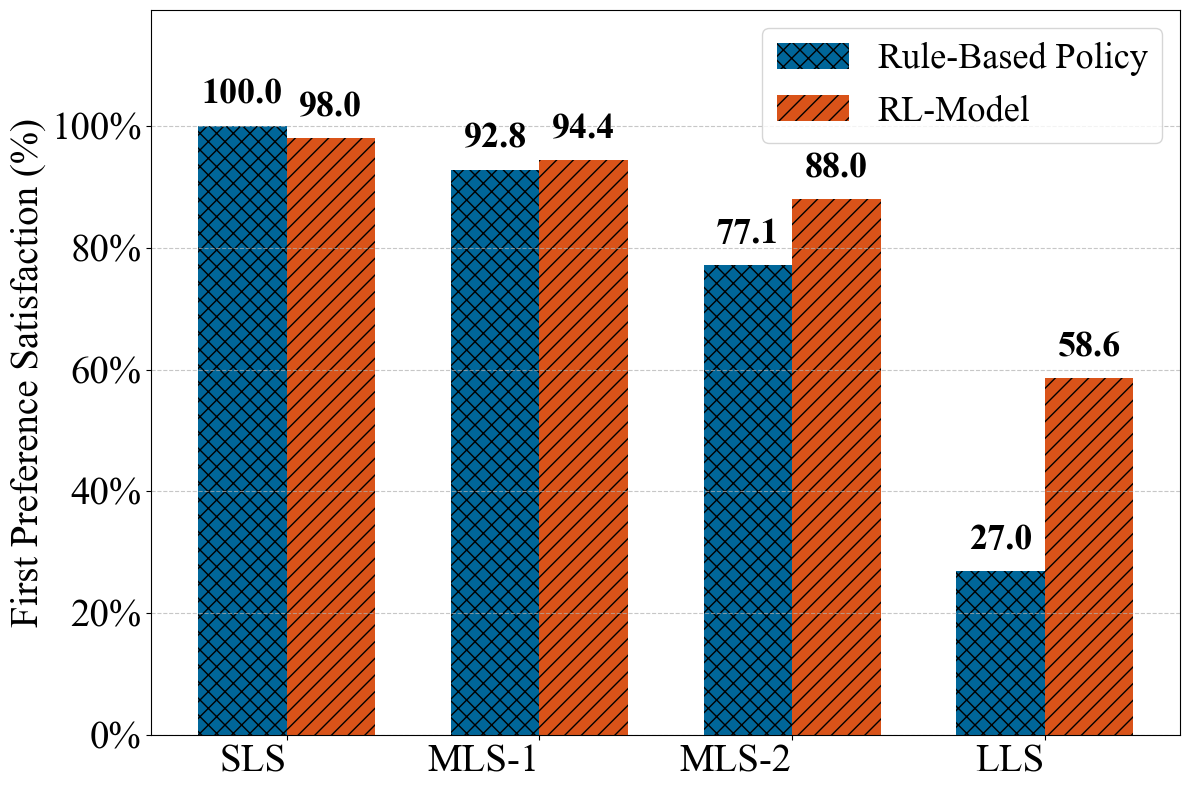

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
data = {
    'Load_System': ['SLS', 'MLS-1', 'MLS-2', 'LLS'],
    'Total_UEs': [50, 250, 350, 1000],
    'First_Pref_Rule-Based': [100.0, 92.8, 77.14, 27.0],
    'First_Pref_RL-Based': [98.0, 94.4, 88.0, 58.6]
}

df = pd.DataFrame(data)

# Plotting
x = np.arange(len(df['Load_System']))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

# Define colors and hatch patterns
rule_based_color = '#006699'  # Dark teal for Rule-Based Policy
rl_based_color = '#D95319'    # Dark red for RL-Based Algorithm
rule_based_hatch = 'xx'       # Hatch pattern for Rule-Based
rl_based_hatch = '//'         # Hatch pattern for RL-Based

# Plot bars with hatch patterns
rects1 = ax.bar(x - width/2, df['First_Pref_Rule-Based'], width, label='Rule-Based Policy', color=rule_based_color, hatch=rule_based_hatch)
rects2 = ax.bar(x + width/2, df['First_Pref_RL-Based'], width, label='RL-Model', color=rl_based_color, hatch=rl_based_hatch)

# Font sizes
plt.rcParams['font.family'] = 'Times New Roman'

rect_fontsize = 26  # Font size for bar labels
label_fontsize = 28
tick_fontsize = 28
title_fontsize = 26
legend_fontsize = 26

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('First Preference Satisfaction (%)', fontsize=label_fontsize)
ax.set_xticks(x)
ax.set_xticklabels(df['Load_System'], rotation=0, ha='right', fontsize=tick_fontsize)
ax.set_ylim(0, max(df['First_Pref_Rule-Based'].max(), 
                   df['First_Pref_RL-Based'].max()) * 1.19)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
ax.legend(fontsize=legend_fontsize)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Function to add percentage labels on top of bars
def autolabel(rects):
    """Attach a text label above each bar displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 10),  # Slightly increased offset for clarity
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=rect_fontsize, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


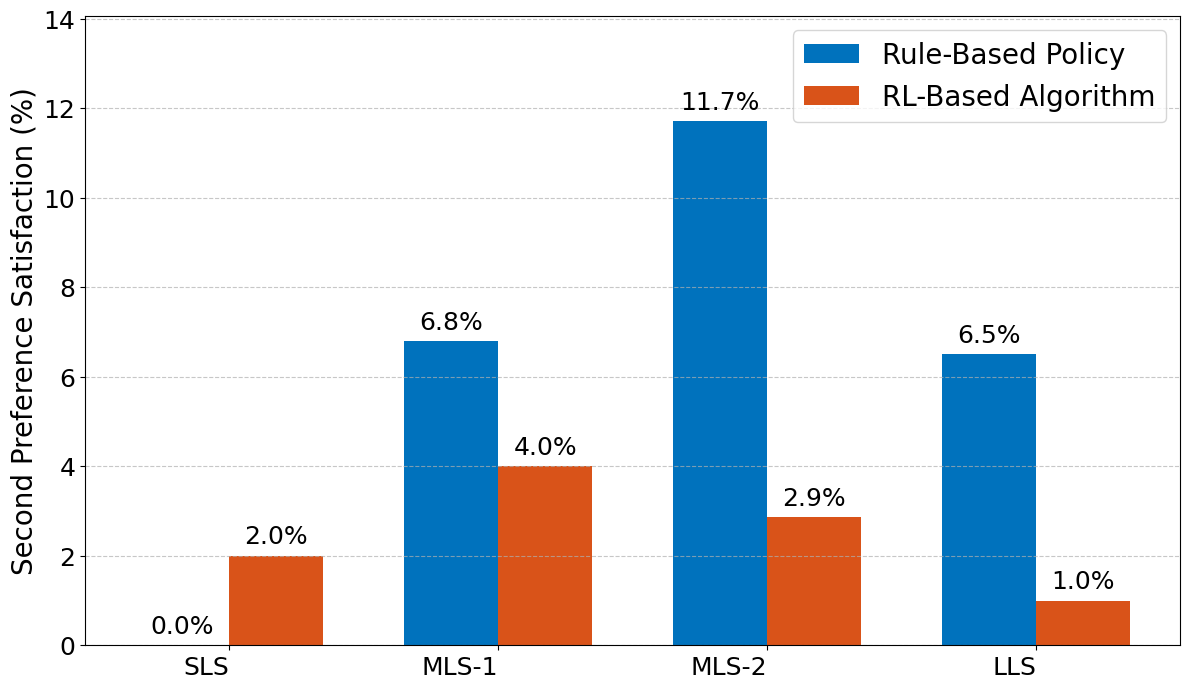

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Using the data from your code
rl_data = {
    'Load_System': ['SLS', 'MLS-1', 'MLS-2', 'LLS'],
    'Total_UEs': [50, 250, 350, 1000],
    'Second_Preference': [1, 10, 10, 10]
}

rule_based_data = {
    'Load_System': ['SLS', 'MLS-1', 'MLS-2', 'LLS'],
    'Total_UEs': [50, 250, 350, 1000],
    'Second_Preference': [0, 17, 41, 65]
}

# Calculate percentages
rl_df = pd.DataFrame(rl_data)
rl_df['Second_Pref_Percentage'] = (rl_df['Second_Preference'] / rl_df['Total_UEs']) * 100

rule_based_df = pd.DataFrame(rule_based_data)
rule_based_df['Second_Pref_Percentage'] = (rule_based_df['Second_Preference'] / rule_based_df['Total_UEs']) * 100

# Plotting
x = np.arange(len(rl_df['Load_System']))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))

rects1 = ax.bar(x - width/2, rule_based_df['Second_Pref_Percentage'], 
                width, label='Rule-Based Policy', color='#0072BD')
rects2 = ax.bar(x + width/2, rl_df['Second_Pref_Percentage'], 
                width, label='RL-Based Algorithm', color='#D95319')

# Font sizes
label_fontsize = 20
tick_fontsize = 18
legend_fontsize = 20

# Add labels and customize plot
ax.set_ylabel('Second Preference Satisfaction (%)', fontsize=label_fontsize)
ax.set_xticks(x)
ax.set_xticklabels(rl_df['Load_System'], rotation=0, ha='right', fontsize=tick_fontsize)
ax.set_ylim(0, max(rule_based_df['Second_Pref_Percentage'].max(), 
                   rl_df['Second_Pref_Percentage'].max()) * 1.2)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.legend(fontsize=legend_fontsize)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Function to add percentage labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=tick_fontsize)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

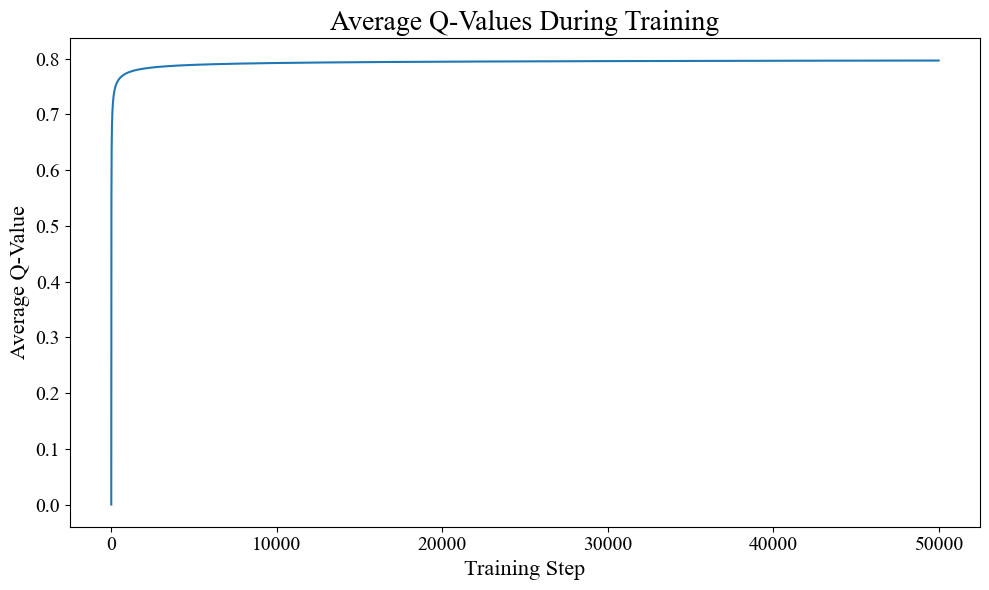

In [108]:
import matplotlib.pyplot as plt

# Example data
# Replace `steps` and `q_values` with your actual data
steps = range(50000)
q_values = [0.8 * (1 - 1 / (x + 1)**0.5) for x in steps]  # Example data for illustration

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(steps, q_values)
ax.set_title('Average Q-Values During Training', fontsize=20)
ax.set_xlabel('Training Step', fontsize=16)
ax.set_ylabel('Average Q-Value', fontsize=16)

# Adjust tick font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show()
